In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nlpaug.util import Action
import nlpaug.augmenter.word as word_augmenter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten, Bidirectional, LSTM, GRU
import re
import string
from wordcloud import WordCloud
from collections import Counter

In [3]:
df = pd.read_csv("/content/Data.csv")

df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
print(f"Shape of dataset is: {df.shape}")

Shape of dataset is: (5572, 2)


In [5]:
df['Category'].unique()

array(['ham', 'spam'], dtype=object)

In [6]:
pd.DataFrame(df.isnull().sum(), columns=['Missing Counts'])

,Missing Counts
Category,0
Message,0


In [7]:
pd.DataFrame(df['Category'].value_counts()).style.background_gradient()

,count
Category,
ham,4825
spam,747


In [8]:
ham_percentage = (df['Category'].value_counts()[0] * 100) / df.shape[0]
spam_percentage = (df['Category'].value_counts()[1] * 100) / df.shape[0]

print(f'Percentage of ham data is: { round(ham_percentage, 2) }')
print(f'Percentage of spam data is: {round(spam_percentage, 2)}')

Percentage of ham data is: 86.59
Percentage of spam data is: 13.41


In [9]:
fig = px.pie(df, names = "Category",
             title = "<b>Counts in Category</b>",
             color_discrete_sequence=px.colors.sequential.Blackbody_r,
             hole = 0.5)

fig.update_layout(title_x = 0.5,
                  title_font = dict(size = 20))

fig.update_traces(textposition='inside',
                  textinfo='percent+label',
                  textfont_size=15,
                  marker=dict(line=dict(color='#000000', width = 1.5)))


fig.show()

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
STOPWORDS = stopwords.words('english')
PUNCTUATION = string.punctuation

In [16]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [17]:
df['Message'] = df['Message'].apply(remove_urls)

In [18]:
df['Message'] = df['Message'].str.lower()

In [19]:
df.head()

,Category,Message
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


In [20]:
def remove_punctuation(series):
    no_punctuation = "".join([word for word in series if word not in PUNCTUATION])
    return no_punctuation

In [21]:
df['Message'] = df['Message'].apply(remove_punctuation)

In [22]:
def remove_extra_white_spaces(series):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string = series)
    return without_sc

In [23]:
df['Message'] = df['Message'].apply(remove_extra_white_spaces)

In [26]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
def remove_stopwords(text):
    no_stopwords = []
    tokens = word_tokenize(text)

    for i in range(len(tokens)):
        if tokens[i] not in STOPWORDS:
            no_stopwords.append(tokens[i])

    return " ".join(no_stopwords)

In [27]:
df["Message"] = df["Message"].apply(remove_stopwords)

In [30]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [28]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

In [31]:
df['Message'] = df['Message'].apply(lemmatize_text)

In [32]:
df['Message_Length'] = df['Message'].apply(len)

In [33]:
df.head()

,Category,Message,Message_Length
0,ham,go jurong point crazy available bugis great wo...,78
1,ham,ok lar joking wif oni,21
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,135
3,ham,u dun say early hor c already say,33
4,ham,nah dont think go usf life around though,40


In [34]:
spam_df = df[df['Category'] == 'spam']

spam_df = spam_df.reset_index().drop('index', axis=1)

In [35]:
spam_counter = Counter()

for sent in spam_df['Message'].values:
    for word in sent.split():
        if word.lower() not in STOPWORDS:
            spam_counter[word] += 1

In [36]:
top_spam_words = pd.DataFrame(spam_counter.most_common(20), columns=['Spam Words', 'Counts'])
top_spam_words.style.background_gradient()

,Spam Words,Counts
0,call,356
1,free,216
2,2,173
3,txt,150
4,ur,144
5,text,137
6,mobile,135
7,4,119
8,stop,115
9,claim,113


In [38]:
fig = px.histogram(top_spam_words,
                   x = 'Spam Words',
                   color_discrete_sequence=[#4a8fdd],
                   y = 'Counts', title="<b>Top 20 Spam Words in dataset</b>")

fig.update_layout(title_x = 0.5,
                  title_font = dict(size = 20))


fig.show()

In [39]:
def plot_word_cloud(dataframe, series):
    try:
        text = ' '.join(dataframe[series])

        wordcloud = WordCloud(width = 1600 , height = 800,
                              background_color ='black',
                              max_words=2000,
                              max_font_size=300,
                              min_font_size = 20).generate(text)

        plt.figure(figsize=(12, 8), facecolor = 'k', edgecolor = 'k' )
        plt.imshow(wordcloud, interpolation = 'bilinear')
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.show()

    except TypeError:
        print("Expected str instance")

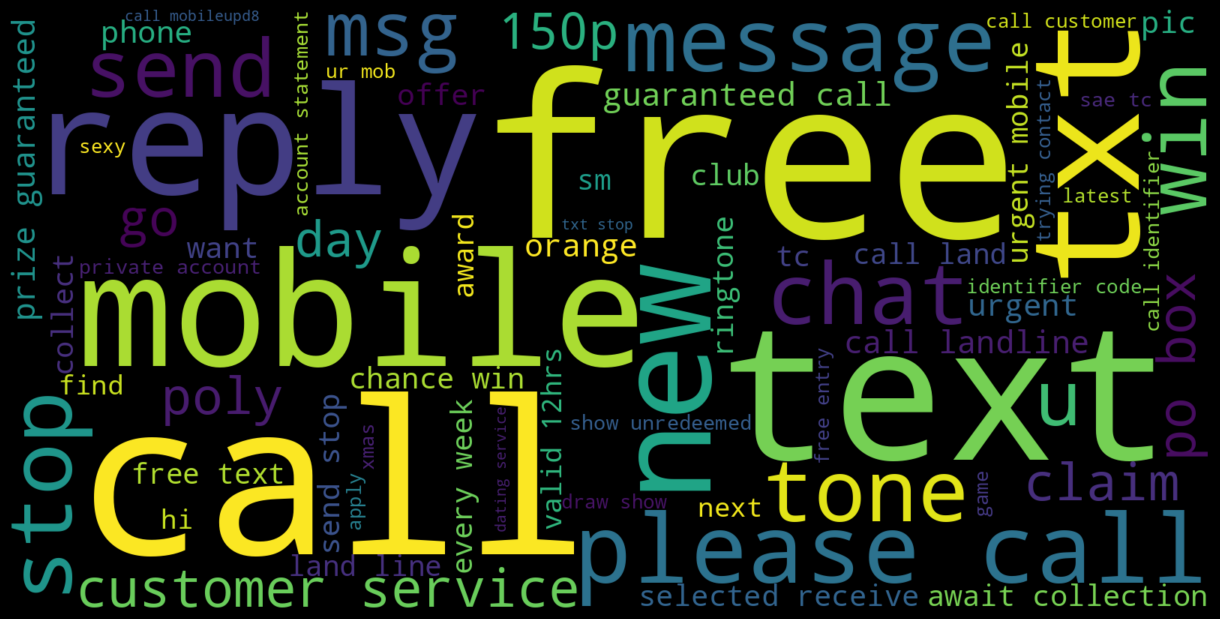

In [40]:
plot_word_cloud(spam_df, "Message")

In [41]:
ham_df = df[df['Category'] == 'ham']

ham_df = ham_df.reset_index().drop('index', axis=1)

In [42]:
ham_counter = Counter()

for sent in ham_df['Message'].values:
    for word in sent.split():
        if word.lower() not in STOPWORDS:
            ham_counter[word] += 1

In [43]:
top_ham_words = pd.DataFrame(ham_counter.most_common(20), columns=['Ham Words', 'Counts'])
top_ham_words.style.background_gradient()

,Ham Words,Counts
0,im,451
1,get,314
2,2,309
3,go,276
4,ltgt,276
5,ok,273
6,dont,265
7,ur,246
8,come,245
9,got,244


In [44]:
fig = px.histogram(top_ham_words,
                   x = 'Ham Words',
                   color_discrete_sequence=[#4a8fdd],
                   y = 'Counts', title="<b>Top 20 Ham Words in dataset</b>")

fig.update_layout(title_x = 0.5,
                  title_font = dict(size = 20))


fig.show()

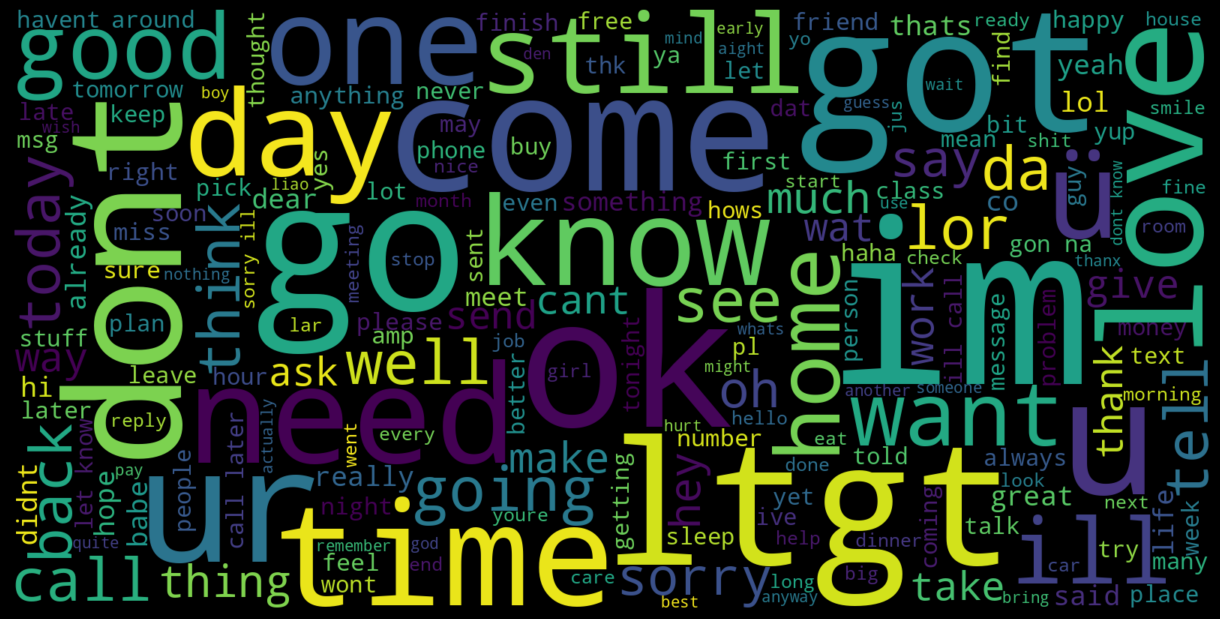

In [45]:
plot_word_cloud(ham_df, "Message")

In [46]:
w_augmenter = word_augmenter.SynonymAug(aug_src='wordnet')

In [47]:
ITERATIONS = 5

# augment data 5 times
def augment_data(dataframe, series, iterations):
    aug_list = list()

    try:
        for i in range(iterations):
            for j in range(len(spam_df)):
                aug_text = w_augmenter.augment(dataframe[series][j])
                aug_list.append(aug_text)

        return aug_list

    except:
        print("Something went wrong")

In [48]:
aug_spam_list = augment_data(spam_df, "Message", ITERATIONS)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [49]:
len(aug_spam_list)

3735

In [50]:
spam_df_aug = pd.DataFrame(aug_spam_list, columns=['Message'])
spam_df_aug.head()

,Message
0,barren entranceway deuce wkly comp gain fa cup...
1,freemsg hey darling 3 week word back id compar...
2,winner valued network client selected receivea...
3,mobile eleven month gas constant entitled upda...
4,vi prospect win john cash 100 20000 pound txt ...


In [51]:
spam_df_aug['Category'] = ['spam' for i in range(len(spam_df_aug))]

In [52]:
spam_df_aug['Message_Length'] = spam_df_aug['Message'].apply(len)

In [53]:
spam_df = pd.concat([spam_df, spam_df_aug])
spam_df.head()

,Category,Message,Message_Length
0,spam,free entry 2 wkly comp win fa cup final tkts 2...,135
1,spam,freemsg hey darling 3 week word back id like f...,87
2,spam,winner valued network customer selected receiv...,120
3,spam,mobile 11 month r entitled update latest colou...,105
4,spam,six chance win cash 100 20000 pound txt csh11 ...,108


In [54]:
spam_df.drop_duplicates(inplace=True)

In [55]:
df = pd.concat([ham_df, spam_df], axis=0)
df = df.reset_index().drop('index', axis=1)

In [ ]:
df.head()

,Category,Message,Message_Length
0,ham,go jurong point crazy available bugis great wo...,78
1,ham,ok lar joking wif oni,21
2,ham,u dun say early hor c already say,33
3,ham,nah dont think go usf life around though,40
4,ham,even brother like speak treat like aid patent,45


In [56]:
pd.DataFrame(df['Category'].value_counts()).style.background_gradient()

,count
Category,
ham,4825
spam,4273


In [57]:
fig = px.pie(df, names = "Category",
             title = "<b>Counts in Category</b>",
             color_discrete_sequence=px.colors.sequential.Blackbody_r,
             hole = 0.5)

fig.update_layout(title_x = 0.5,
                  title_font = dict(size = 20))

fig.update_traces(textposition='inside',
                  textinfo='percent+label',
                  textfont_size=15,
                  marker=dict(line=dict(color='#000000', width = 1.5)))


fig.show()

In [58]:
df['Category'] = df['Category'].map({"spam" : 1,
                                     "ham" : 0})

In [59]:
df.head()

,Category,Message,Message_Length
0,0,go jurong point crazy available bugis great wo...,78
1,0,ok lar joking wif oni,21
2,0,u dun say early hor c already say,33
3,0,nah dont think go usf life around though,40
4,0,even brother like speak treat like aid patent,45


In [60]:
message = df['Message'].values
category = df['Category'].values

In [61]:
VOCAB_SIZE = 1000
MAX_LEN = df['Message_Length'].max()
EMBEDDING_VECTOR_SIZE = 6

In [62]:
encoded_message = [one_hot(msg, VOCAB_SIZE) for msg in message]

In [63]:
padded_message = pad_sequences(encoded_message, maxlen=MAX_LEN, padding='post')

In [64]:
X = padded_message
y = category

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [66]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_VECTOR_SIZE, input_length = MAX_LEN, name='Embedding'))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 513, 6)            6000      
                                                                 
 bidirectional (Bidirection  (None, 513, 256)          138240    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               123648    
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4

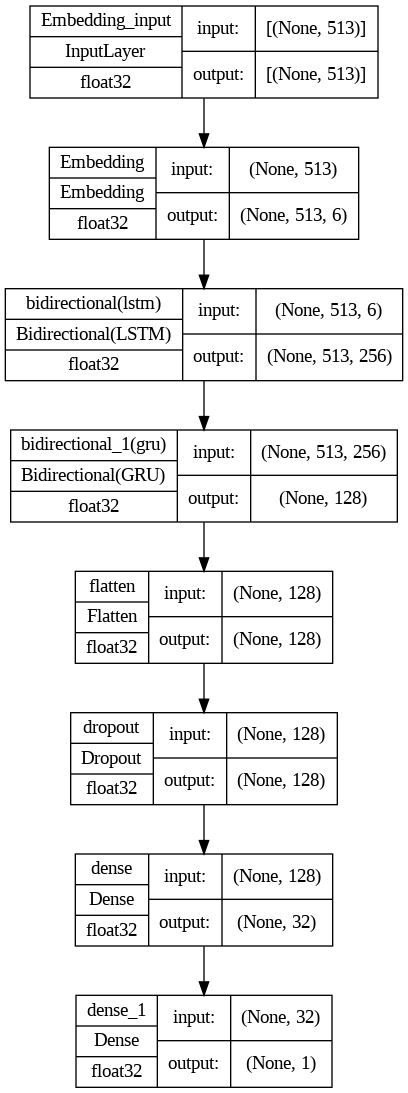

In [68]:
plot_model(model, show_dtype=True, show_layer_names=True, show_shapes=True)

In [69]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [70]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=15, batch_size=100)

Epoch 1/15
69/69 [==============================] - 26s 223ms/step - loss: 0.3786 - accuracy: 0.8230 - val_loss: 0.1691 - val_accuracy: 0.9336
Epoch 2/15
69/69 [==============================] - 10s 148ms/step - loss: 0.1112 - accuracy: 0.9609 - val_loss: 0.0990 - val_accuracy: 0.9613
Epoch 3/15
69/69 [==============================] - 10s 139ms/step - loss: 0.0683 - accuracy: 0.9755 - val_loss: 0.1031 - val_accuracy: 0.9609
Epoch 4/15
69/69 [==============================] - 8s 121ms/step - loss: 0.0434 - accuracy: 0.9848 - val_loss: 0.1011 - val_accuracy: 0.9666
Epoch 5/15
69/69 [==============================] - 8s 111ms/step - loss: 0.1439 - accuracy: 0.9817 - val_loss: 0.0956 - val_accuracy: 0.9648
Epoch 6/15
69/69 [==============================] - 7s 106ms/step - loss: 0.0349 - accuracy: 0.9892 - val_loss: 0.1268 - val_accuracy: 0.9631
Epoch 7/15
69/69 [==============================] - 8s 115ms/step - loss: 0.0249 - accuracy: 0.9930 - val_loss: 0.1241 - val_accuracy: 0.9644
Epo

In [71]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epoch = [i + 1 for i in range(len(train_acc))]

In [72]:
acc_loss_df = pd.DataFrame({"Training Loss" : train_loss,
                            "Validation Loss": val_loss,
                            "Train Accuracy" : train_acc,
                            "Validation Accuracy" : val_acc,
                            "Epoch":epoch})


acc_loss_df.style.bar(color = COLOR)

,Training Loss,Validation Loss,Train Accuracy,Validation Accuracy,Epoch
0,0.378628,0.169122,0.822952,0.933626,1
1,0.111151,0.099007,0.960868,0.961319,2
2,0.068325,0.103066,0.975524,0.960879,3
3,0.043450,0.101134,0.984757,0.966593,4
4,0.143913,0.095610,0.981680,0.964835,5
5,0.034874,0.126837,0.989154,0.963077,6
6,0.024856,0.124071,0.992965,0.964396,7
7,0.015131,0.171891,0.995457,0.962198,8
8,0.015457,0.149932,0.996482,0.961758,9
9,0.012368,0.172261,0.996922,0.962637,10


In [73]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = acc_loss_df['Epoch'],
                         y = acc_loss_df['Train Accuracy'],
                         mode='lines+markers',
                         name='Training Accuracy'))

fig.add_trace(go.Scatter(x = acc_loss_df['Epoch'],
                         y = acc_loss_df['Validation Accuracy'],
                         mode='lines+markers',
                         name = 'Validation Accuracy'))

fig.update_layout(title = {'text': "<b>Training Accuracy Vs Validation Accuracy</b>\n",
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'y':0.9,'x':0.5,},
                  xaxis_title="Epoch",
                  yaxis_title = "Accuracy",
                  title_font = dict(size = 20))

fig.layout.template = 'plotly_dark'

fig.show()

In [74]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = acc_loss_df['Epoch'],
                         y = acc_loss_df['Training Loss'],
                         mode='lines+markers',
                         name='Training Loss'))

fig.add_trace(go.Scatter(x = acc_loss_df['Epoch'],
                         y = acc_loss_df['Validation Loss'],
                         mode='lines+markers',
                         name = 'Validation Loss'))

fig.update_layout(title = {'text': "<b>Training Loss Vs Validation Loss</b>\n",
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'y':0.9,'x':0.5,},
                  xaxis_title="Epoch",
                  yaxis_title = "Loss",
                  title_font = dict(size = 20))

fig.layout.template = 'plotly_dark'

fig.show()

In [75]:
loss, acc = model.evaluate(X_test, y_test)

72/72 [==============================] - 2s 29ms/step - loss: 0.2058 - accuracy: 0.9578


In [77]:
pred = (model.predict(X_test) > 0.5).astype("int32")

72/72 [==============================] - 3s 30ms/step


In [78]:
print(classification_report(y_test, pred, target_names = ['Ham','Spam']))

              precision    recall  f1-score   support

         Ham       0.97      0.95      0.96      1203
        Spam       0.95      0.97      0.96      1072

    accuracy                           0.96      2275
   macro avg       0.96      0.96      0.96      2275
weighted avg       0.96      0.96      0.96      2275



In [79]:
cm = confusion_matrix(y_test,pred)
cm

array([[1143,   60],
       [  36, 1036]])

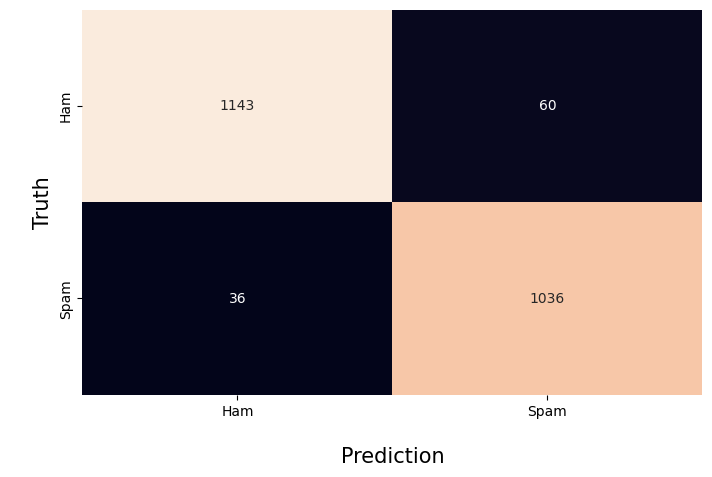

In [80]:
classes = ['Ham','Spam']

plt.figure(figsize = (8,5))
sns.heatmap(cm, annot = True, fmt = 'd', cbar=False).set(xticklabels = classes, yticklabels = classes)
plt.xlabel("\nPrediction", size = 15)
plt.ylabel("\nTruth",  size = 15)
plt.show()

Testing

In [82]:
def predict_category(text):
    text = remove_punctuation(text)
    text = text.lower()

    encoded_text = [one_hot(text, VOCAB_SIZE)]
    padded_text = pad_sequences(encoded_text, maxlen=MAX_LEN, padding='post')

    pred = (model.predict(padded_text) > 0.5).astype("int32")
    pred = pred.flatten()[0]

    return "SPAM" if pred == 1 else "HAM"

In [83]:
text = "Get free service and win a prize just call this number 12103239293"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 42ms/step
Text is: Get free service and win a prize just call this number 12103239293

Category: SPAM


In [84]:
text = "Free free, you have a chance to win prize"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 39ms/step
Text is: Free free, you have a chance to win prize

Category: SPAM


In [85]:
text = "WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! claim"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 52ms/step
Text is: WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! claim

Category: SPAM


In [86]:
text = "Clcik this link to win prize"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 38ms/step
Text is: Clcik this link to win prize

Category: SPAM


In [87]:
text = "Hi, we are going for trip this weekend"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 53ms/step
Text is: Hi, we are going for trip this weekend

Category: HAM


In [89]:
text = "Did you make a tea?"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 55ms/step
Text is: Did you make a tea?

Category: SPAM


In [90]:
text = "Your free trail is going to end, renew it"

category = predict_category(text)

print(f"Text is: {text}\n")
print(f"Category: {category}")

1/1 [==============================] - 0s 38ms/step
Text is: Your free trail is going to end, renew it

Category: HAM
